In [11]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from datetime import datetime as dt

from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR, get_tensor_dataset, encode_batch, BL62_VALUES, BL62FREQ_VALUES, get_array_dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold, get_mean_roc_curve, get_pred_df, get_mean_pr_curve
from src.train_eval import train_loop, nested_kcv_train_nn, evaluate_trained_models_nn
from src.train_eval import kcv_tune_sklearn, evaluate_trained_models_sklearn, nested_kcv_train_sklearn
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump

if torch.cuda.is_available():    
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device = "cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'
    
from src.partition_tools import pipeline_stratified_kfold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
RESDIR='../output/220906_analysis/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3070 Laptop GPU


In [122]:
from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon

# init

## reloading datasets

In [12]:
cedar = pd.read_csv('../data/partitioned_traindata_redo/cedar_10fold.csv')
cedar['trainset']='cedar'

cedar_viral_old = pd.read_csv('../data/partitioned_traindata/cedar_viral_10fold.csv')
cedar_viral_old['trainset']='cedar_virus_old'

cedar_viral_more = pd.read_csv('../data/partitioned_traindata_redo/new_cedar_viral_5fold.csv')
cedar_viral_more['trainset']='cedar_virus_new'
# USE PRIME FOR BASELINE VERIFICATION, PRIME_FOLD FOR ACTUAL TRAINING
prime_fold = pd.read_csv('../data/partitioned_traindata_redo/prime_5fold.csv')
prime_fold['trainset']='prime'

prime = pd.read_excel('../data/partitioned_traindata/PRIME_dataset.xlsx', comment = '#', skiprows=2)

viral_only = pd.read_csv('../data/partitioned_traindata_redo/viral_only_5fold.csv')
viral_only['trainset']='virus'

cedar_hp_uni = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_rank120_10fold.csv')
cedar_hp_uni['trainset']='cedar_hp_rank_uni'

cedar_hp_low = pd.read_csv('../data/partitioned_traindata/cedar_hp_mixed_10fold.csv')
cedar_hp_low['trainset']='cedar_hp_rank_low'

# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

In [13]:
# nn align
nndir = '../../../nnalign/partitioned_output/_old/'
nnalign_cedar = pd.read_csv(f'{nndir}cedar.pep_39077/cedar.pep_39077.lg6.sorted.pred', sep = '\t')
nnalign_cedar_hp_low = pd.read_csv(f'{nndir}cedar_hp_low.pep_34256/cedar_hp_low.pep_34256.lg6.sorted.pred', sep = '\t')
nnalign_cedar_hp_uni = pd.read_csv(f'{nndir}cedar_hp_uni.pep_28097/cedar_hp_uni.pep_28097.lg6.sorted.pred', sep = '\t')
nnalign_cedar_viral = pd.read_csv(f'{nndir}cedar_viral.pep_2684/cedar_viral.pep_2684.lg6.sorted.pred', sep = '\t')
nnalign_prime = pd.read_csv(f'{nndir}prime.pep_12391/prime.pep_12391.lg6.sorted.pred', sep = '\t')

In [14]:
# PRIME
primedir='../../../gfeller_tools/PRIME/output/'
prime_cedar = pd.read_csv(f'{primedir}cedar_PRIME.out', comment = '#', sep = '\t')
prime_cedar_hp_low = pd.read_csv(f'{primedir}cedar_hp_low_PRIME.out', comment = '#', sep = '\t')
prime_cedar_hp_uni = pd.read_csv(f'{primedir}cedar_hp_uni_PRIME.out', comment = '#', sep = '\t')
prime_cedar_viral = pd.read_csv(f'{primedir}cedar_viral_PRIME.out', comment = '#', sep = '\t')
prime_prime = pd.read_csv(f'{primedir}prime_PRIME.out', comment = '#', sep = '\t')

### Merging w/ baseline scores

In [15]:
import copy
def merging(df, df_nnalign, df_prime):
    df = df.sort_values('Peptide', ascending=True).reset_index(drop=True)
    df_nnalign = df_nnalign.sort_values('Peptide', ascending=True).reset_index(drop=True)
    df_prime = df_prime.sort_values('Peptide', ascending=True).reset_index(drop=True)
    out = copy.deepcopy(df)
    tmp = df_nnalign.rename(columns={'Prediction':'nnalign_score'}).merge(df_prime.rename(columns={'%Rank_bestAllele':'MixMHCrank',
                                                    'Score_bestAllele':'PRIME_score',
                                                    'BestAllele':'MixMHCallele'})[['Peptide', 'MixMHCrank', 'PRIME_score', 'MixMHCallele']],
                           left_index=True, right_index=True)
    out = out.merge(tmp, left_index=True, right_index=True)
    return out

In [16]:
cedar = merging(cedar, nnalign_cedar, prime_cedar)
cedar_hp_low = merging(cedar_hp_low, nnalign_cedar_hp_low, prime_cedar_hp_low)
cedar_hp_uni = merging(cedar_hp_uni, nnalign_cedar_hp_uni, prime_cedar_hp_uni)
cedar_viral_old = merging(cedar_viral_old, nnalign_cedar_viral, prime_cedar_viral)
prime = merging(prime.rename(columns={'Mutant':'Peptide'}), nnalign_prime, prime_prime)

### quick roc check

Text(0.5, 1.0, 'baselines for PRIME dataset (w/o HP negs)')

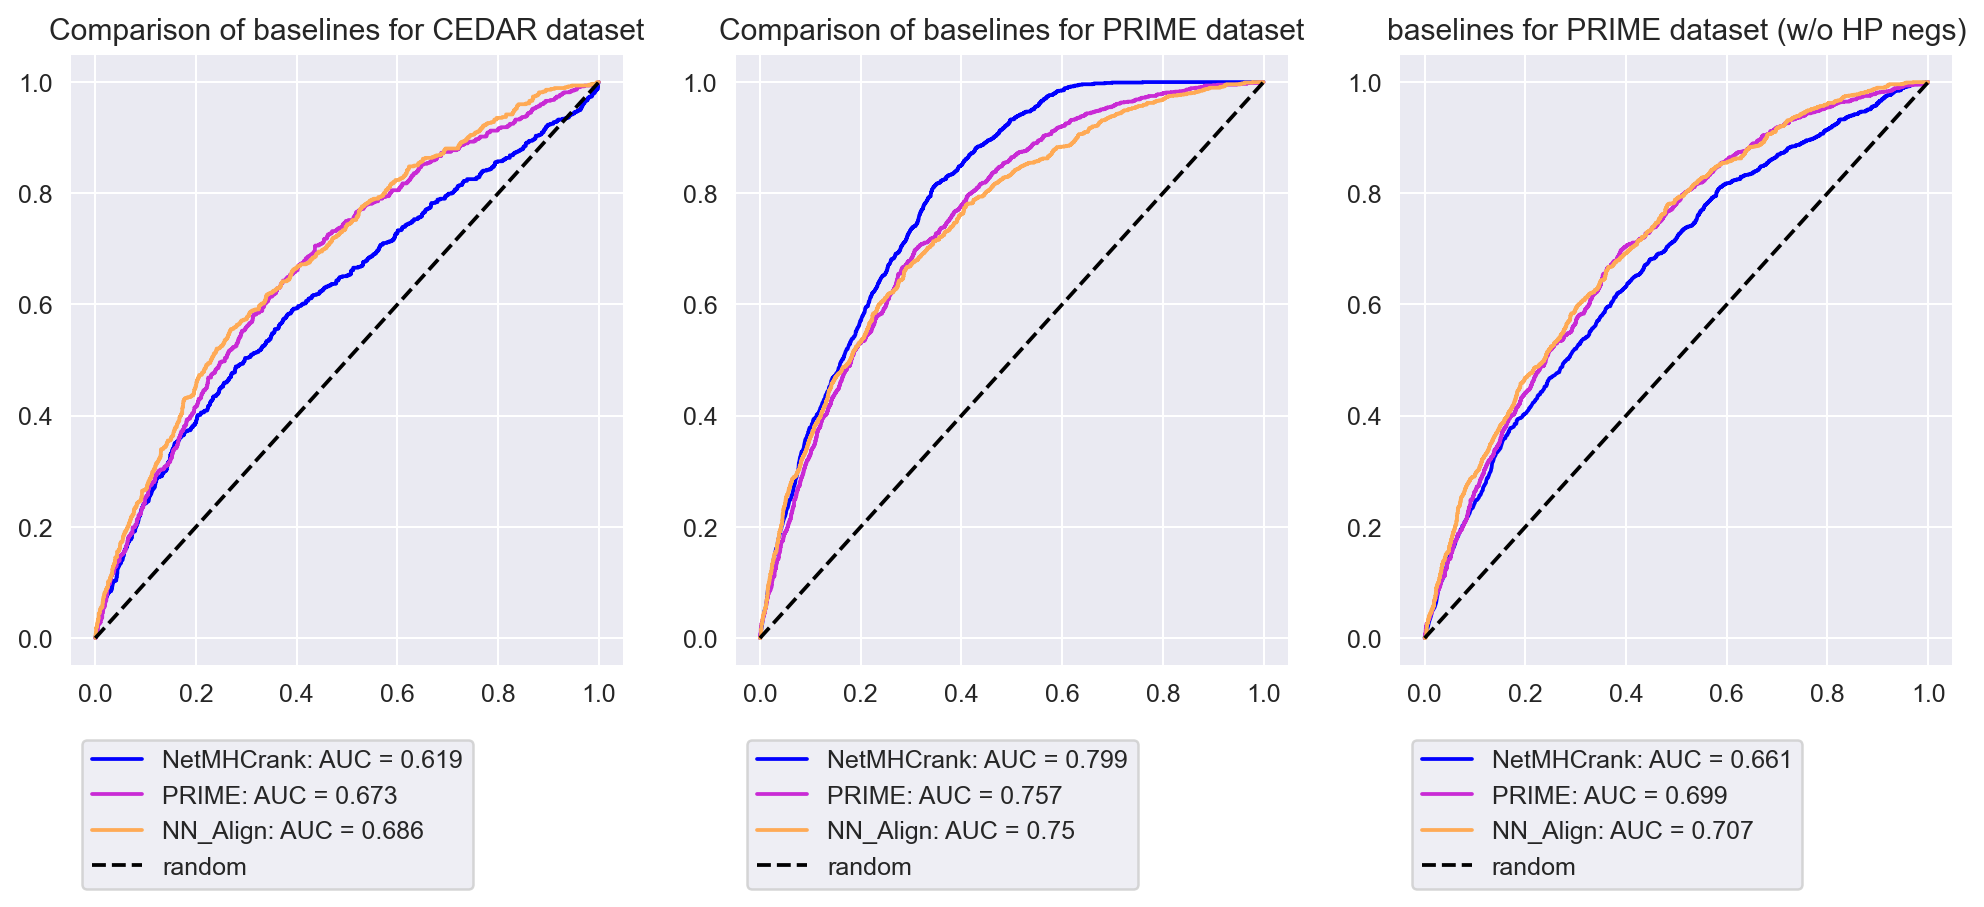

In [17]:
# For CEDAR
from sklearn.metrics import roc_auc_score, roc_curve
#FOR CEDAR
# EL rank
fpr_netmhc, tpr_netmhc, _ = roc_curve(cedar['agg_label'].values,  -1* cedar['trueHLA_EL_rank'].values)
auc_netmhc = roc_auc_score(cedar['agg_label'].values, -1*cedar['trueHLA_EL_rank'].values)
# PRIME
fpr_prime, tpr_prime, _ = roc_curve(cedar['agg_label'].values, cedar['PRIME_score'].values)
auc_prime = roc_auc_score(cedar['agg_label'].values, cedar['PRIME_score'].values)
# nnalign
fpr_nnalign, tpr_nnalign, _ = roc_curve(cedar['agg_label'].values, cedar['nnalign_score'].values)
auc_nnalign = roc_auc_score(cedar['agg_label'].values, cedar['nnalign_score'].values)

sns.set_palette('gnuplot2', n_colors=3)
f,a = plt.subplots(1,3, figsize=(13.5,4.5))
a[0].plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}')
a[0].plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}')
a[0].plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}')
a[0].plot([0,1],[0,1], label='random', ls = '--', c='k')
a[0].legend(bbox_to_anchor=(0.75, -0.1))
a[0].set_title('Comparison of baselines for CEDAR dataset')
# FOR PRIME
# EL rank
fpr_netmhc, tpr_netmhc, _ = roc_curve(prime['Immunogenicity'].values,  -1* prime['NetMHCpanEL'].values)
auc_netmhc = roc_auc_score(prime['Immunogenicity'].values, -1*prime['NetMHCpanEL'].values)
# PRIME
fpr_prime, tpr_prime, _ = roc_curve(prime['Immunogenicity'].values, prime['PRIME_score'].values)
auc_prime = roc_auc_score(prime['Immunogenicity'].values, prime['PRIME_score'].values)
# nnalign
fpr_nnalign, tpr_nnalign, _ = roc_curve(prime['Immunogenicity'].values, prime['nnalign_score'].values)
auc_nnalign = roc_auc_score(prime['Immunogenicity'].values, prime['nnalign_score'].values)

a[1].plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}')
a[1].plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}')
a[1].plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}')
a[1].plot([0,1],[0,1], label='random', ls = '--', c='k')
a[1].legend(bbox_to_anchor=(0.75, -0.1))
a[1].set_title('Comparison of baselines for PRIME dataset')


tmp = prime.query('StudyOrigin!="Random"')
fpr_netmhc, tpr_netmhc, _ = roc_curve(tmp['Immunogenicity'].values,  -1* tmp['NetMHCpanEL'].values)
auc_netmhc = roc_auc_score(tmp['Immunogenicity'].values, -1*tmp['NetMHCpanEL'].values)
# PRIME
fpr_prime, tpr_prime, _ = roc_curve(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
auc_prime = roc_auc_score(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
# nnalign
fpr_nnalign, tpr_nnalign, _ = roc_curve(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
auc_nnalign = roc_auc_score(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
a[2].plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}')
a[2].plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}')
a[2].plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}')
a[2].plot([0,1],[0,1], label='random', ls = '--', c='k')
a[2].legend(bbox_to_anchor=(0.75, -0.1))
a[2].set_title('baselines for PRIME dataset (w/o HP negs)')

### BASELINE ROCS

In [18]:
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, roc_curve, roc_auc_score

def plot_baseline_roc(axis, dataset, remove_hp=False):
    if dataset=='cedar':
        fpr_netmhc, tpr_netmhc, _ = roc_curve(cedar['agg_label'].values,  -1* cedar['trueHLA_EL_rank'].values)
        auc_netmhc = roc_auc_score(cedar['agg_label'].values, -1*cedar['trueHLA_EL_rank'].values)
        # PRIME
        fpr_prime, tpr_prime, _ = roc_curve(cedar['agg_label'].values, cedar['PRIME_score'].values)
        auc_prime = roc_auc_score(cedar['agg_label'].values, cedar['PRIME_score'].values)
        # nnalign
        fpr_nnalign, tpr_nnalign, _ = roc_curve(cedar['agg_label'].values, cedar['nnalign_score'].values)
        auc_nnalign = roc_auc_score(cedar['agg_label'].values, cedar['nnalign_score'].values)
    elif dataset=='prime':
        
        tmp = prime.query('StudyOrigin != "Random"') if remove_hp else prime
        
        fpr_netmhc, tpr_netmhc, _ = roc_curve(tmp['Immunogenicity'].values,  -1* tmp['NetMHCpanEL'].values)
        auc_netmhc = roc_auc_score(prime['Immunogenicity'].values, -1*tmp['NetMHCpanEL'].values)
        # PRIME
        fpr_prime, tpr_prime, _ = roc_curve(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
        auc_prime = roc_auc_score(prime['Immunogenicity'].values, tmp['PRIME_score'].values)
        # nnalign
        fpr_nnalign, tpr_nnalign, _ = roc_curve(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
        auc_nnalign = roc_auc_score(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
    
    axis.plot(fpr_netmhc, tpr_netmhc, label = f'NetMHCrank: AUC = {round(auc_netmhc,3)}',
              linestyle='-.', lw=0.45, color='m')
    axis.plot(fpr_prime, tpr_prime, label = f'PRIME: AUC = {round(auc_prime,3)}',
              linestyle='-.', lw=0.45, color='g')
    axis.plot(fpr_nnalign, tpr_nnalign, label = f'NN_Align: AUC = {round(auc_nnalign,3)}',
              linestyle='-.', lw=0.45, color='c')

    
def plot_baseline_pr(axis, dataset, remove_hp=False):
    if dataset=='cedar':
        precision_netmhc, recall_netmhc, _ = precision_recall_curve(cedar['agg_label'].values,  -1* cedar['trueHLA_EL_rank'].values)
        prauc_netmhc = auc(recall_netmhc, precision_netmhc)
        # PRIME
        precision_prime, recall_prime, _ = precision_recall_curve(cedar['agg_label'].values, cedar['PRIME_score'].values)
        prauc_prime = auc(recall_prime, precision_prime)
        # nnalign
        precision_nnalign, recall_nnalign, _ = precision_recall_curve(cedar['agg_label'].values, cedar['nnalign_score'].values)
        prauc_nnalign = auc(recall_nnalign, precision_nnalign)
        
    elif dataset=='prime':
        tmp = dataset.query('StudyOrigin != "Random"') if remove_hp else prime
        
        precision_netmhc, recall_netmhc, _ = precision_recall_curve(tmp['Immunogenicity'].values,  -1* tmp['NetMHCpanEL'].values)
        prauc_netmhc = auc(recall_netmhc, precision_netmhc)
        # PRIME
        precision_prime, recall_prime, _ = precision_recall_curve(tmp['Immunogenicity'].values, tmp['PRIME_score'].values)
        prauc_prime = auc(recall_prime, precision_prime)
        # nnalign
        precision_nnalign, recall_nnalign, _ = precision_recall_curve(tmp['Immunogenicity'].values, tmp['nnalign_score'].values)
        prauc_nnalign = auc(recall_nnalign, precision_nnalign)
    
    axis.plot(recall_netmhc, precision_netmhc, label = f'NetMHCrank: PRAUC = {round(prauc_netmhc,3)}',
              linestyle='-.', lw=0.45, color='m')
    axis.plot(recall_prime, precision_prime, label = f'PRIME: PRAUC = {round(prauc_prime,3)}',
              linestyle='-.', lw=0.45, color='g')
    axis.plot(recall_nnalign, precision_nnalign, label = f'NN_Align: PRAUC = {round(prauc_nnalign,3)}',
              linestyle='-.', lw=0.45, color='c')


# Bootstrap

## fct defs

In [279]:
from joblib import Parallel, delayed
from functools import partial
from src.metrics import get_metrics


def bootstrap_wrapper(y_score, y_true, seed):    
    # np.random.seed(seed) fuck this
    np.random.seed(None)
    sample_idx = np.random.randint(0, len(y_score), len(y_score))
    sample_score = y_score[sample_idx]
    sample_true = y_true[sample_idx]
    test_results = get_metrics(sample_true, sample_score)
    
    # Save to get mean curves after
    roc_curve = (test_results.pop('roc_curve'), test_results['auc'])
    # Same
    pr_curve = (test_results.pop('pr_curve'), test_results['prauc'])
    
    return pd.DataFrame(test_results, index=[0]), roc_curve, pr_curve


def bootstrap_eval(y_score, y_true, n_rounds=10000, n_jobs=16):
    """
    sample_size should be a float
    """
    wrapper = partial(bootstrap_wrapper, 
                      y_score=y_score, y_true=y_true)
    
    output = Parallel(n_jobs=n_jobs)(delayed(wrapper)(seed=seed) for seed in tqdm(range(n_rounds), desc='Bootstrapping rounds', position=1))
    result_df = pd.concat([x[0] for x in output])
    mean_roc_curve = get_mean_roc_curve([x[1] for x in output])
    # mean_pr_curve = get_mean_pr_curve([x[2] for x in output])
    return result_df, mean_roc_curve, [x[2] for x in output]

In [230]:
def load_hyperparams(encoding_kwargs, train_dataset, MAPPING, model, blosum_matrix=None, weight = None):
    outdict = {'trainset': train_dataset['trainset'].unique()[0],
                       'model': MAPPING[model.__class__.__name__],
                       'weight': weight} # Hardcoded here
            
    if blosum_matrix is not None:
        bl_name = 'BL62LO' if blosum_matrix['A'].dtype == np.int64 else 'BL62FREQ'
        outdict['blsm'] = bl_name
        
    outdict.update({k: v for k, v in encoding_kwargs.items() if k != 'blosum_matrix'})
    outname = '_'.join([f'{k}{v}' for k, v in outdict.items()])
    
    pkl_name = convert_path(os.path.join(f'../output/tuning/{MAPPING[model.__class__.__name__].lower()}_bootstrap', (outname + '.pkl')).replace('//', '/'))
    hyperparams = pkl_load(pkl_name)
    if 'max_depth' in hyperparams:
        if np.isnan(hyperparams['max_depth']):
            hyperparams['max_depth'] = None
        else:
    
            hyperparams['max_depth'] = int(hyperparams['max_depth'])
    
    for k in [x for x in hyperparams.keys() if x.startswith('n_')]:
        # converts n_estimators, n_layers, n_in, n_hidden, to int
        hyperparams[k] = int(hyperparams[k])
    return hyperparams

## check trainset - add_rank

### runs

In [ ]:
all_results = {}
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': False,  # Using Shannon ICs, true if both mask and name is "shannon"
                   'add_rank': False,
                   'add_aaprop': False,
                   'remove_pep': False,
                   'standardize': True}
blosum_matrix = None

tmp_prime = prime_fold.query('StudyOrigin != "Random"')


# DICT with multiple levels: 1 for add_rank, 1 more for model, 1 more for train_dataset, 1 more for df/curve
# --> all_results['True']['XGB']['cedar']['df_prime'] to get the results of prime

for add_rank in [True, False]:
    encoding_kwargs.update({'add_rank':add_rank})
    # All results['True']
    all_results[str(add_rank)] = {}
    for model in [XGBClassifier(verbosity=0, method='gpu_hist', n_jobs=1, subsample=0.75), 
                  RandomForestClassifier(n_jobs=1, min_samples_leaf = 7)]:
        # all_results['True']['XGB']
        all_results[str(add_rank)][MAPPING[model.__class__.__name__]] = {}
        
        for train_dataset in tqdm(
                                    [cedar,
                                     cedar_viral_old,
                                     cedar_viral_more,
                                     viral_only,
                                     prime_fold,
                                     cedar_hp_uni,
                                     cedar_hp_low
                                    ],
                                  desc = 'trainset', position=0):
            
            trainset_name = train_dataset.trainset.unique().item()
            # all_results['True']['XGB']['CEDAR'] = {}
            all_results[str(add_rank)][MAPPING[model.__class__.__name__]][trainset_name] = {}
            # Reload params
            hyperparams = load_hyperparams(encoding_kwargs, train_dataset, MAPPING, model, blosum_matrix)
            model.set_params(**hyperparams)
            
            trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model, ics_dict=None,
                                                            encoding_kwargs=encoding_kwargs)
            # EVAL + BOOTSTRAP ON CEDAR TEST SET
            _, concat_pred, concat_true = evaluate_trained_models_sklearn(test_dataframe=cedar, models_dict=trained_models, 
                                                                          ics_dict=None, train_dataframe=train_dataset,
                                                                          train_metrics=train_metrics, encoding_kwargs=encoding_kwargs,
                                                                          concatenated=True, return_scores=True)
                
            results_df, mean_rocs, _ = bootstrap_eval(y_score = concat_pred,
                                                      y_true = concat_true, 
                                                      n_rounds=10000, n_jobs = 16)
            
            results_df['trainset'] = trainset_name
            results_df['model'] = MAPPING[model.__class__.__name__]
            
            all_results[str(add_rank)][MAPPING[model.__class__.__name__]][trainset_name]['df_cedar'] = results_df
            all_results[str(add_rank)][MAPPING[model.__class__.__name__]][trainset_name]['mean_rocs_cedar'] = mean_rocs
            # EVAL + BOOTSTRAP ON PRIME TEST SET
            _, concat_pred, concat_true = evaluate_trained_models_sklearn(test_dataframe=tmp_prime, models_dict=trained_models, 
                                                                          ics_dict=None, train_dataframe=train_dataset,
                                                                          train_metrics=train_metrics, encoding_kwargs=encoding_kwargs,
                                                                          concatenated=True, return_scores=True)
            results_df, mean_rocs, _ = bootstrap_eval(y_score = concat_pred,
                                                      y_true = concat_true, 
                                                      n_rounds=10000, n_jobs = 16)
            results_df['trainset'] = trainset_name
            results_df['model'] = MAPPING[model.__class__.__name__]
            
            all_results[str(add_rank)][MAPPING[model.__class__.__name__]][trainset_name]['df_prime'] = results_df
            all_results[str(add_rank)][MAPPING[model.__class__.__name__]][trainset_name]['mean_rocs_prime'] = mean_rocs
            # results[trainset_name]['all_prs'] = all_prs
            
            
            all_results[str(add_rank)][MAPPING[model.__class__.__name__]][trainset_name]['model'] = trained_models
pkl_dump(all_results, '../output/bootstrapping/trainset_models.pkl')

trainset:   0%|          | 0/7 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

1592


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

19824


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

1589


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

19514


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

1594


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

9746


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

7824


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

10516


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

6931


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

2089


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

1590


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

19731


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

1606


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

20023


trainset:   0%|          | 0/7 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

1582


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

19653


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

1585


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

19433


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

1597


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

9753


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

7819


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

10463


Outer fold:   0%|          | 0/5 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/4 [00:00<?, ?it/s]

Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

6891


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

2146


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

1580


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

19652


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

1620


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

20015


trainset:   0%|          | 0/7 [00:00<?, ?it/s]

Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

1582


Bootstrapping rounds:   0%|          | 0/10000 [00:00<?, ?it/s]

19552


Outer fold:   0%|          | 0/10 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

Inner fold:   0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
df_rank_trainset_model_cedar = []
df_rank_trainset_model_prime = []

for add_rank in [True,False]:
    for model, value_model in all_results[str(add_rank)].items():
        for trainset, value_trainset in value_model.items():
            
            df_cedar = value_trainset['df_cedar']
            df_cedar['add_rank']=add_rank
            df_rank_trainset_model_cedar.append(df_cedar)
            
            df_prime = value_trainset['df_prime']
            df_prime['add_rank']=add_rank
            df_rank_trainset_model_prime.append(df_prime)
            
df_rank_trainset_model_cedar= pd.concat(df_rank_trainset_model_cedar)
df_rank_trainset_model_cedar.to_csv('../output/bootstrapping/df_rank_trainset_model_cedar.csv', index=False)
df_rank_trainset_model_prime= pd.concat(df_rank_trainset_model_prime)
df_rank_trainset_model_prime.to_csv('../output/bootstrapping/df_rank_trainset_model_prime.csv', index=False)

### plots 

In [ ]:
# Overall boxplot
f,a = plt.subplots(1,1, figsize=(7,4.3))
sns.set_palette([HSV[0], HSV[1]])
x_order = ['cedar', 'cedar_hp_rank_uni', 'cedar_hp_rank_low', 'cedar_virus_old', 'cedar_virus_new', 'virus', 'prime']
sns.boxplot(data=df_rank_trainset_model_cedar.query('model=="RF"'), ax=a, hue_order = [True, False],
            x='trainset', hue='add_rank', y='auc',
            order = x_order)
a.set_xticklabels(labels = x_order, rotation = 35, fontdict={'horizontalalignment':'right'})
a.set_title('Boxplot of AUCS for Random Forest models trained on various datasets\nBootstrapped evaluation on CEDAR test set using sample frac=0.33 and 300 rounds.')

In [ ]:
# X-Y lm plot
df_rank_trainset_concat = pd.merge(left=df_rank_trainset_model_cedar.rename(columns={'auc':'Score_CEDAR_AUC'})[['Score_CEDAR_AUC', 'trainset', 'model', 'add_rank']]\
                                                                .sort_values(['trainset','model','add_rank']).reset_index(drop=True),
                                    right=df_rank_trainset_model_prime.rename(columns={'auc':'Score_PRIME_AUC'})\
                                                                .sort_values(['trainset','model','add_rank']).reset_index(drop=True)['Score_PRIME_AUC'],
                                   left_index=True, right_index=True)


sns.set_palette(HSV)
f = plt.Figure(figsize=(7,6))

# f.set_axis_labels('CEDAR dataset AUC', 'PRIME dataset AUC')
sns.lmplot(data=df_rank_trainset_concat.query('add_rank==True and model=="RF"'),
           x='Score_CEDAR_AUC', y='Score_PRIME_AUC', hue='trainset',
           markers = ['x', 'o', '*', '+', '8', 's', 'p'],
           scatter_kws={"alpha":0.55,"s":3}, line_kws={'lw':1.2,'ls':'--'})

plt.plot([0.5,0.8],[0.5,.8], lw=0.25, ls='--', c='k')
# plt.xlim = [0.4, 0.75]
# plt.ylim = [0.4, 0.75]
plt.xlabel('CEDAR dataset AUC')
plt.ylabel('PRIME dataset AUC')

plt.title('Concat CEDAR test AUC vs Concat PRIME AUC\n for different training sets')

In [ ]:
# ROC PLOT
sns.set_palette(HSV, n_colors=7)
f,a = plt.subplots(1,1, figsize=(6,6), sharey=True)
# a[0].plot([0,1], [0,1], ls = '--', lw= 0.5, label = 'Random prediction', c='k')


# all_results[str(add_rank)][MAPPING[model.__class__.__name__]][trainset_name]['model'] 

for model in ['XGB', 'RF']:
    mean_cedar_roc = all_results[str(True)][model]['cedar']['mean_rocs_cedar']
    sns.lineplot(x=mean_cedar_roc[0],y=mean_cedar_roc[1], ax=a, 
                     label = f'{model} +%Rank={True}; AUC={round(mean_cedar_roc[4],3)}', estimator=None)
    a.fill_between(np.linspace(0, 1, len(mean_cedar_roc[0])), mean_cedar_roc[2], mean_cedar_roc[3], alpha=0.1)
        
    mean_cedar_roc = all_results[str(False)][model]['cedar']['mean_rocs_cedar']
    sns.lineplot(x=mean_cedar_roc[0],y=mean_cedar_roc[1], ax=a, 
                     label = f'{model} +%Rank={False}; AUC={round(mean_cedar_roc[4],4)}', estimator=None)
    a.fill_between(np.linspace(0, 1, len(mean_cedar_roc[0])), mean_cedar_roc[2], mean_cedar_roc[3], alpha=0.1)
    
a.plot([0,1], [0,1], ls = '--', lw= 0.5, label = 'Random prediction', c='k')
# a.legend(bbox_to_anchor = (1.05, .67))#
a.legend(bbox_to_anchor= (.81, -.091))
f.suptitle('Comparison of ROCs for different methods and adding Rank, using CEDAR as training dataset\nBootstrapped evaluation on CEDAR test set using sample frac=0.33 and 300 rounds.')


In [ ]:
df_rank_trainset_model_cedar

In [ ]:
# LONE BOXPLOT WITH PVALUE
df_tmp = df_rank_trainset_model_cedar.query('trainset=="cedar" and model=="RF"').rename(columns={'auc':'CEDAR AUC',
                                                                                                 'add_rank': 'Add Rank'})
df_tmp2 = df_rank_trainset_model_cedar.query('trainset=="cedar" and add_rank==True').rename(columns={'auc':'CEDAR AUC'})
sns.set_palette(HSV)
f,a = plt.subplots(1,2, figsize=(8,5))

# FIRST (left boxplot to check Add Rank on CEDAR with pval)
sns.boxplot(data=df_tmp, x='Add Rank', y='CEDAR AUC', hue='Add Rank',  
            ax = a[0], saturation = 0.55, width = 0.4, dodge=False, boxprops=dict(alpha=.75))
sns.swarmplot(data= df_tmp, x='Add Rank', y='CEDAR AUC', hue='Add Rank', 
              ax = a[0], alpha = 0.6, size = 1.25, dodge=False)

rank_true = df_tmp.query('`Add Rank`==True')['CEDAR AUC'].values
rank_false = df_tmp.query('`Add Rank`==False')['CEDAR AUC'].values
pval = ttest_ind(rank_true, rank_false, alternative='greater')[1]
label= f'*\np={pval:.3e}' if pval<0.025 else f'ns, p={pval:.3f}'
# Drawing Pval */ns rectangles
x1, x2 = 0, 1
y, h, col = .76-0.0025, 0.0025, 'k'
a[0].plot([x1,x1,x2,x2], [y, y+h, y+h, y], lw = 2, c=col)
a[0].set_ylim([0.64, 0.77])
a[0].text((x1+x2)*.5, y+h, label, ha = 'center', va = 'bottom', color = col)
# a.set_title(binder)


# FIRST (left boxplot to check Add Rank on CEDAR with pval
sns.boxplot(data=df_tmp2, x='model', y='CEDAR AUC', hue='model',  
            ax = a[1], saturation = 0.55, width = 0.4, dodge=False, boxprops=dict(alpha=.75))
sns.swarmplot(data= df_tmp2, x='model', y='CEDAR AUC', hue='model', 
              ax = a[1], alpha = 0.6, size = 1.25, dodge=False)

score_xgb = df_tmp2.query('model=="XGB"')['CEDAR AUC'].values
score_rf = df_tmp2.query('model=="RF"')['CEDAR AUC'].values
pval = ttest_ind(score_rf, score_xgb, alternative='greater')[1]
label= f'*\np={pval:.3e}' if pval<0.025 else f'ns, p={pval:.3f}'
# Drawing Pval */ns rectangles
x1, x2 = 0, 1
y, h, col = .76-0.0025, 0.0025, 'k'
a[1].set_ylabel(None)
a[1].plot([x1,x1,x2,x2], [y, y+h, y+h, y], lw = 2, c=col)
a[1].set_ylim([0.64, 0.77])
a[1].text((x1+x2)*.5, y+h, label, ha = 'center', va = 'bottom', color = col)
# a.set_title(binder)
f.suptitle('Bootstrapped evaluation on CEDAR test set using sample frac=0.33 and 300 rounds.\n Comparison with p-values of one-sided T-tests')

In [ ]:
df_rank_trainset_concat = pd.concat(df_rank_trainset_model_cedar.rename(columns={'auc':'Score_CEDAR_AUC'})[['Score_CEDAR_AUC', 'trainset', 'model', 'add_rank']],
                                    df_rank_trainset_model_prime.rename(columns={'auc':'Score_CEDAR_AUC'})[['Score_CEDAR_AUC', 'trainset', 'model', 'add_rank']],

In [ ]:
# concat = []
# for k in all_results.keys():
#     for k1, v in all_results[k].items():
#         concat.append(v['df']) #.to_csv(f'{k}{k1}.csv', index=False)
# df = pd.concat(concat)

f,a = plt.subplots(1,1,figsize=(6,4))

melted = df_rank_trainset_model_cedar.melt(id_vars = 'trainset', value_vars = ['auc', 'f1', 'auc_01'], var_name ='metric', value_name = 'value')
sns.boxplot(data=melted, x='metric', y='value', hue = 'trainset')
a.legend(bbox_to_anchor = (.66, -.15))

Text(0.5, 1.0, 'Boxplot of AUCs for Random Forest models trained on different datasets\nbootstrapped evaluation on CEDAR\nUsing frac=0.33, N_rounds=300')

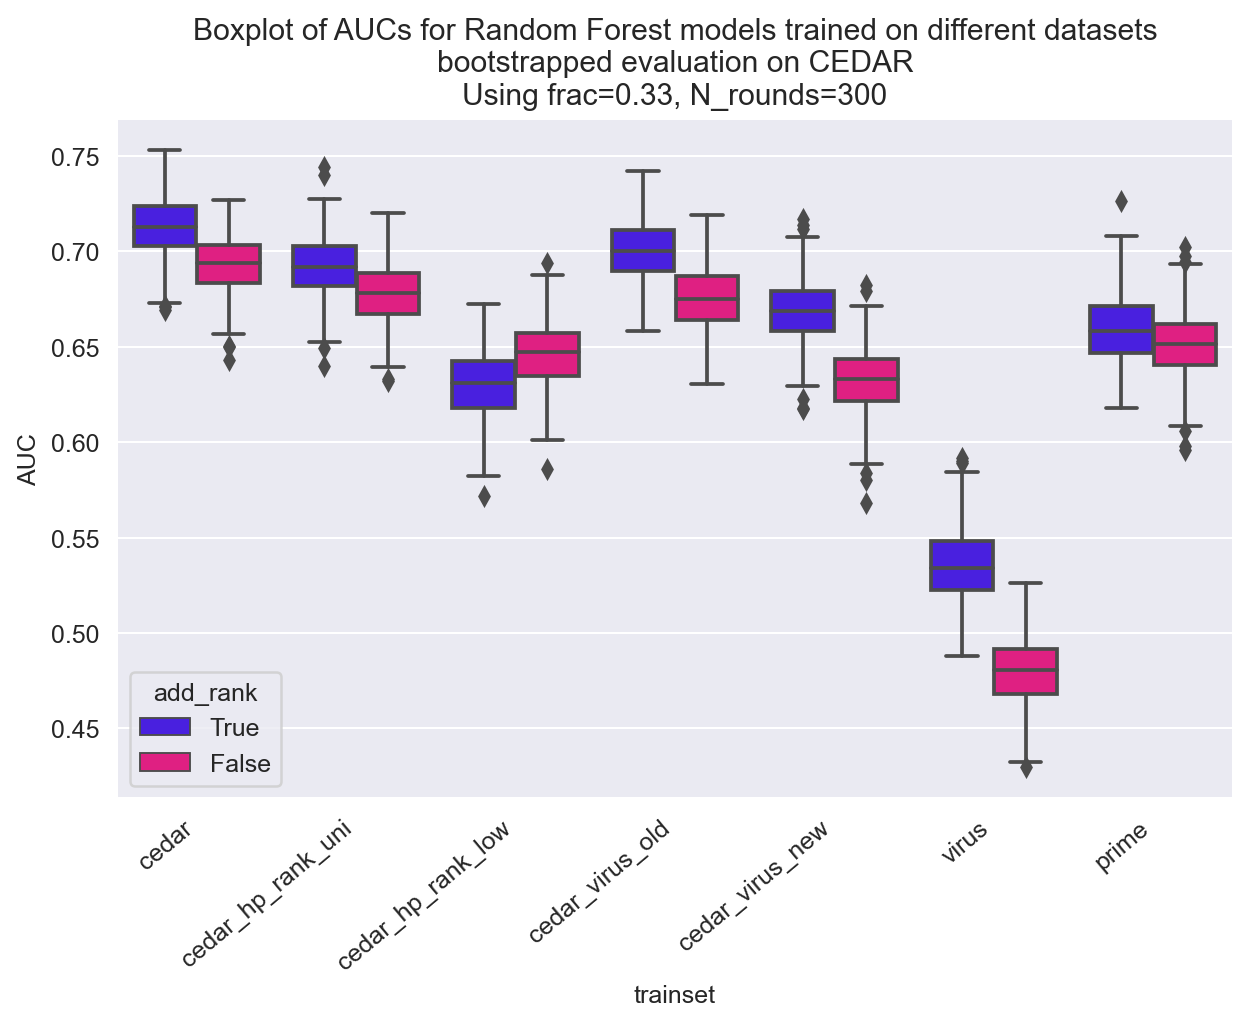

In [56]:
# OVERALL boxplot
sns.set_palette([HSV[0], HSV[1]])
f,a = plt.subplots(1,1, figsize=(8,5))

x_order = ['cedar', 'cedar_hp_rank_uni', 'cedar_hp_rank_low', 'cedar_virus_old', 'cedar_virus_new', 'virus', 'prime']
sns.boxplot(data=df_rank_trainset_model_cedar.query('model=="RF"').rename(columns={'auc':'AUC'}), order=x_order,
            y='AUC', hue = 'add_rank', x= 'trainset', hue_order = [True, False])

a.set_xticklabels(labels = x_order, fontdict={'horizontalalignment':'right'}, rotation = 40)
a.set_title('Boxplot of AUCs for Random Forest models trained on different datasets\nbootstrapped evaluation on CEDAR\nUsing frac=0.33, N_rounds=300')

Text(0.5, 0.98, 'Comparison of performance for different training set\nUsing bootstrap (frac=0.33,N=300) evaluation on CEDAR test set')

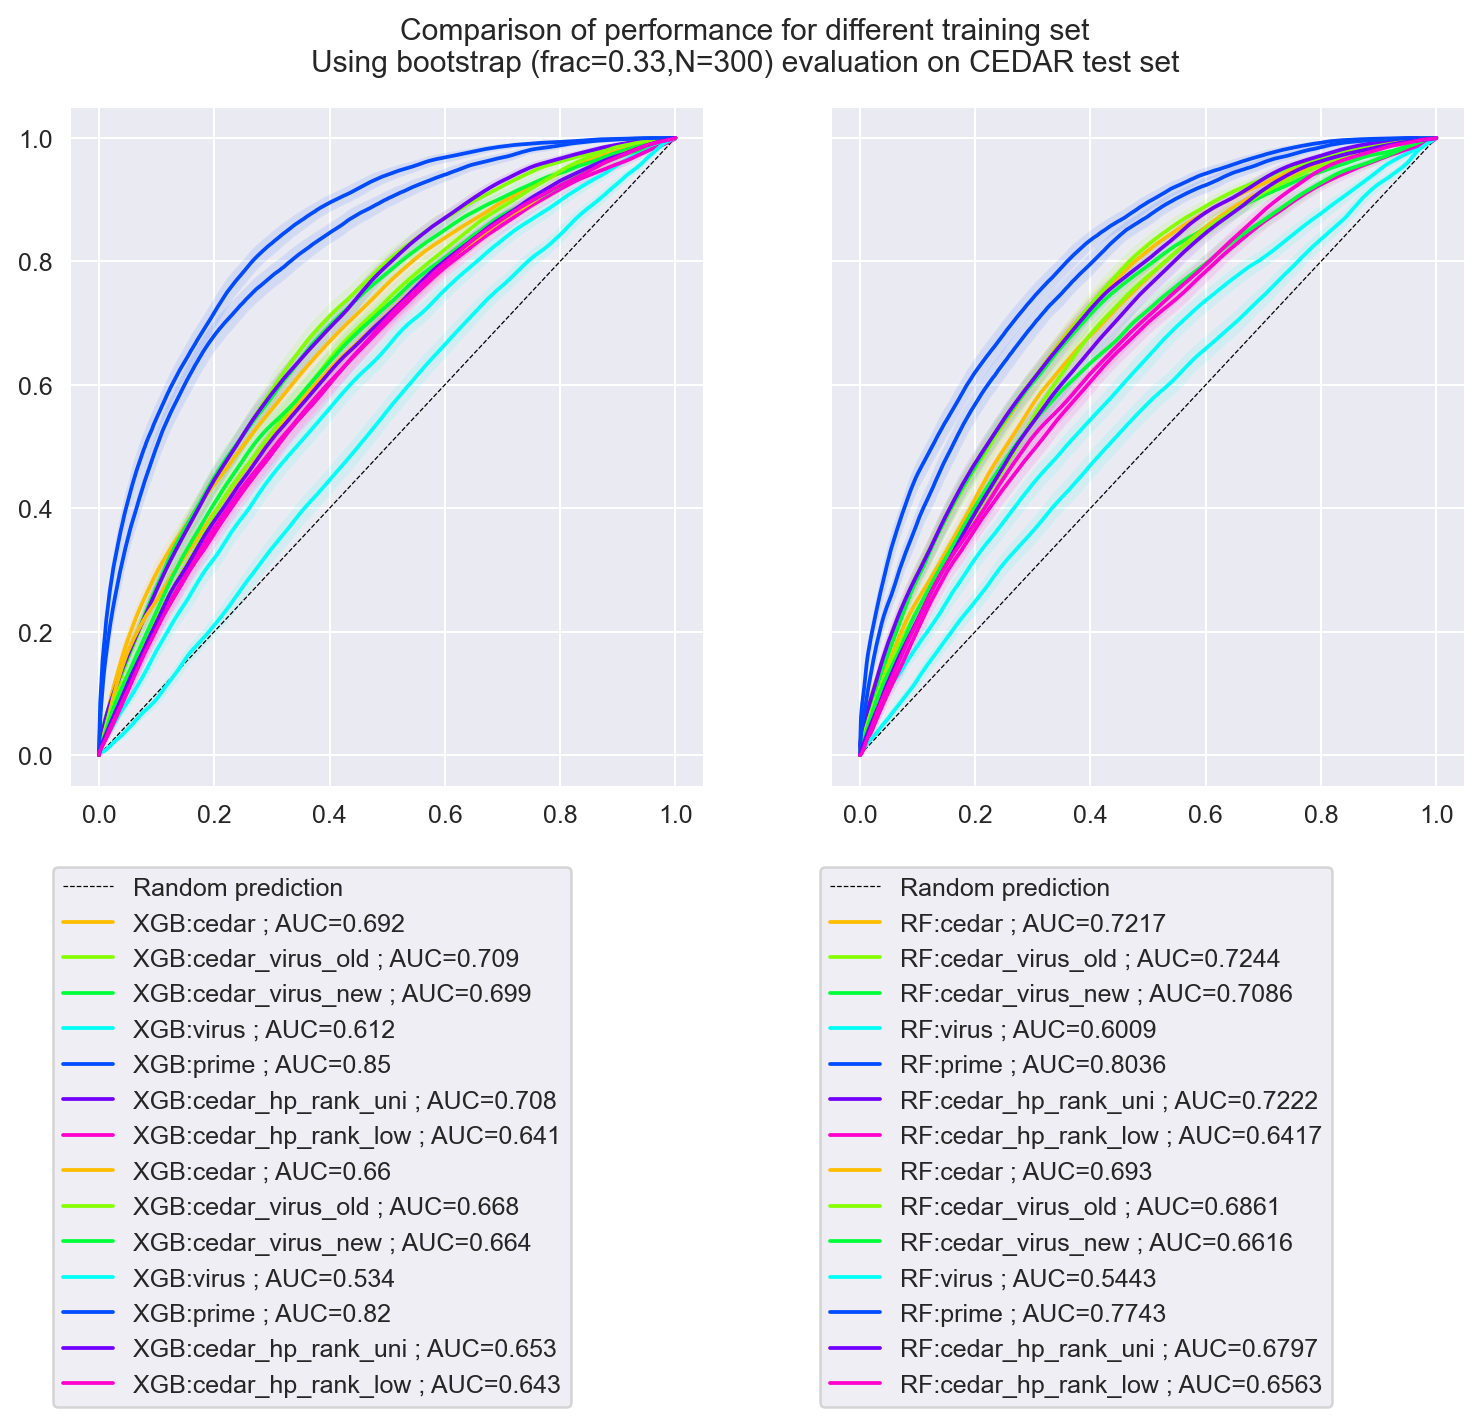

In [30]:
# ROC check
sns.set_palette('hsv', n_colors=7)
f,a = plt.subplots(1,2, figsize=(10, 5), sharey=True)
a[0].plot([0,1], [0,1], ls = '--', lw= 0.5, label = 'Random prediction', c='k')
a[1].plot([0,1], [0,1], ls = '--', lw= 0.5, label = 'Random prediction', c='k')

for add_rank in [True, False]:
    for k,v  in all_results[str(add_rank)]['XGB'].items():
        mean_cedar_roc = v['mean_rocs_prime']# all_results['XGB']['cedar']['mean_rocs']
        sns.lineplot(x=mean_cedar_roc[0],y=mean_cedar_roc[1], ax=a[0], 
                     label = f'XGB:{k} ; AUC={round(mean_cedar_roc[4],3)}', estimator=None)
        a[0].fill_between(np.linspace(0, 1, len(mean_cedar_roc[0])), mean_cedar_roc[2], mean_cedar_roc[3], alpha=0.1)
        
    for k,v  in all_results[str(add_rank)]['RF'].items():
        mean_cedar_roc = v['mean_rocs_prime']# all_results['XGB']['cedar']['mean_rocs']
        sns.lineplot(x=mean_cedar_roc[0],y=mean_cedar_roc[1], ax=a[1], 
                     label = f'RF:{k} ; AUC={round(mean_cedar_roc[4],4)}', estimator=None)
        a[1].fill_between(np.linspace(0, 1, len(mean_cedar_roc[0])), mean_cedar_roc[2], mean_cedar_roc[3], alpha=0.1)

a[0].legend(bbox_to_anchor= (.81, -.1))   
a[1].legend(bbox_to_anchor= (.81, -.1))
f.suptitle('Comparison of performance for different training set\nUsing bootstrap (frac=0.33,N=300) evaluation on CEDAR test set')


## Checking Encoding & Weights

In [ ]:
def load_hyperparams(encoding_kwargs, train_dataset, MAPPING, model, blosum_matrix=None, weight = None):
    outdict = {'trainset': train_dataset['trainset'].unique()[0],
                       'model': MAPPING[model.__class__.__name__],
                       'weight': weight} # Hardcoded here
            
    if blosum_matrix is not None:
        bl_name = 'BL62LO' if blosum_matrix['A'].dtype == np.int64 else 'BL62FREQ'
        outdict['blsm'] = bl_name
        
    outdict.update({k: v for k, v in encoding_kwargs.items() if k != 'blosum_matrix'})
    outname = '_'.join([f'{k}{v}' for k, v in outdict.items()])
    
    pkl_name = convert_path(os.path.join(f'../output/tuning/{MAPPING[model.__class__.__name__].lower()}_bootstrap', (outname + '.pkl')).replace('//', '/'))
    hyperparams = pkl_load(pkl_name)
    if 'max_depth' in hyperparams:
        if np.isnan(hyperparams['max_depth']):
            hyperparams['max_depth'] = None
        else:
    
            hyperparams['max_depth'] = int(hyperparams['max_depth'])
    
    for k in [x for x in hyperparams.keys() if x.startswith('n_')]:
        # converts n_estimators, n_layers, n_in, n_hidden, to int
        hyperparams[k] = int(hyperparams[k])
    return hyperparams

In [ ]:
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES
enc_weight_results = {}
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix': None,
                   'mask': False,  # Using Shannon ICs, true if both mask and name is "shannon"
                   'add_rank': True,
                   'add_aaprop': False,
                   'remove_pep': False,
                   'standardize': True}
train_dataset = cedar
model = RandomForestClassifier(n_jobs=1, min_samples_leaf = 7)
tmp_prime = prime_fold.query('StudyOrigin != "Random"')
for encoding, blosum_matrix, blsm_name in zip(['onehot', 'blosum', 'blosum'], 
                                              [None, BL62_VALUES, BL62FREQ_VALUES],
                                              ['onehot', 'BL62LO', 'BL62FREQ']):
    
    encoding_kwargs['encoding']=encoding
    encoding_kwargs['blosum_matrix']=blosum_matrix
    
    enc_weight_results[blsm_name] = {}
    
    for ic_name, ics_dict in zip(['Mask', 'KL', 'None', 'Shannon'], [ics_shannon, ics_kl, None, ics_shannon]):
        encoding_kwargs['mask'] = True if ic_name =='Mask' else False
        
        enc_weight_results[blsm_name][ic_name]={}        
        trainset_name = train_dataset.trainset.unique().item()
        ###################################################
        # THIS BLOCK IS COPIED FROM THE NESTED KCV SCRIPT #
        ###################################################
        hyperparams = load_hyperparams(encoding_kwargs, train_dataset, MAPPING, model, blosum_matrix, weight=ic_name)
        model.set_params(**hyperparams)

        ###################################################
        trained_models, train_metrics, _ = nested_kcv_train_sklearn(train_dataset, model, ics_dict=ics_dict,
                                                        encoding_kwargs=encoding_kwargs)
        ############EVAL CEDAR############
        _, concat_pred, concat_true = evaluate_trained_models_sklearn(test_dataframe=cedar, models_dict=trained_models, 
                                                                      ics_dict=ics_dict, train_dataframe=train_dataset,
                                                                      train_metrics=train_metrics, encoding_kwargs=encoding_kwargs,
                                                                      concatenated=True, return_scores=True)
            
        results_df, mean_rocs, _ = bootstrap_eval(y_score = concat_pred,
                                                  y_true = concat_true, 
                                                  n_rounds=10000, n_jobs = 16)

        results_df['trainset'] = trainset_name
        results_df['model'] = MAPPING[model.__class__.__name__]
        results_df['encoding'] = blsm_name
        results_df['weight'] = ic_name
        results_df.to_csv(f'../output/bootstrapping/{MAPPING[model.__class__.__name__]}_{trainset}_{blsm_name}_{ic_name}_cedar.csv', index=False)
        enc_weight_results[blsm_name][ic_name]['df_cedar'] = results_df
        enc_weight_results[blsm_name][ic_name]['mean_rocs_cedar'] = mean_rocs
        
        ###########EVAL PRIME ############
        _, concat_pred, concat_true = evaluate_trained_models_sklearn(test_dataframe=tmp_prime, models_dict=trained_models, 
                                                                      ics_dict=ics_dict, train_dataframe=train_dataset,
                                                                      train_metrics=train_metrics, encoding_kwargs=encoding_kwargs,
                                                                      concatenated=True, return_scores=True)
        results_df, mean_rocs, _ = bootstrap_eval(y_score = concat_pred,
                                                  y_true = concat_true, 
                                                  n_rounds=10000, n_jobs = 16)

        results_df['trainset'] = trainset_name
        results_df['model'] = MAPPING[model.__class__.__name__]
        results_df['encoding'] = blsm_name
        results_df['weight'] = ic_name
        results_df.to_csv(f'../output/bootstrapping/{MAPPING[model.__class__.__name__]}_{trainset}_{blsm_name}_{ic_name}_prime.csv', index=False)
        enc_weight_results[blsm_name][ic_name]['df_prime'] = results_df
        enc_weight_results[blsm_name][ic_name]['mean_rocs_prime'] = mean_rocs
        
        enc_weight_results[blsm_name][ic_name]['model'] = trained_models
    

pkl_dump(enc_weight_results, '../output/bootstrapping/encoding_weighting.pkl')

In [ ]:
df_encoding_weight_cedar = []
df_encoding_weight_prime = []
for blsm_name in ['onehot', 'BL62LO', 'BL62FREQ']:
    for ic_name in ['Shannon', 'KL', 'None', 'Mask']:
        df_cedar = value_trainset['df_cedar']
        # df_cedar['add_rank']=add_rank
        df_encoding_weight_cedar.append(df_cedar)
        
        df_prime = value_trainset['df_prime']
        # df_prime['add_rank']=add_rank
        df_encoding_weight_prime.append(df_prime)
        
df_encoding_weight_cedar= pd.concat(df_encoding_weight_cedar)
df_encoding_weight_cedar.to_csv('../output/bootstrapping/df_encoding_weight_cedar_rankTrue_modelRF_trainsetcedar.csv', index=False)
df_encoding_weight_prime= pd.concat(df_encoding_weight_prime)
df_encoding_weight_prime.to_csv('../output/bootstrapping/df_encoding_weight_prime_rankTrue_modelRF_trainsetcedar.csv', index=False)